# Forecasting air pollution with RNNs
### result    
1. Simple RNN
2. Simple LSTM
3. Stacked LSTM

## 0. Import Packages

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

import tensorflow as tf
import idw
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

## 1. Make Dataset

In [2]:
dataset = np.zeros((314,1))

for hour in range(24) :
    path = os.path.join(os.getcwd(), 'air_pollution_data', 'Hour_{}'.format(hour+1) + '.csv')
    csv = pd.read_csv(path, encoding = 'cp949', header = None)
    csv.head()
    data = csv.values[:,-1]
    data = data.reshape(314,1)
    
    dataset = np.concatenate((dataset, data), axis = 1)
    
dataset = dataset[:, 1:]    

In [3]:
# dataset = dataset.reshape(314,24)

In [4]:
# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(dataset)

In [5]:
dataset = dataset.reshape(314,1,24)
print("Shape of dataset :", dataset.shape)

Shape of dataset : (314, 1, 24)


In [6]:
x = dataset[:, :, :23]
y = dataset[:, :, -1]

In [7]:
print("Shape of x :", x.shape)
print("Shape of y :", y.shape)

Shape of x : (314, 1, 23)
Shape of y : (314, 1)


In [8]:
x_train = x[:251,:,:]
y_train = y[:251,:]

x_test = x[252:,:,:]
y_test = y[252:,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(251, 1, 23) (251, 1)
(62, 1, 23) (62, 1)


## 2-1. Simple RNN

In [151]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(16, input_shape=(1,23)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

In [21]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
losses = tf.compat.v1.losses.log_loss


In [23]:
simple_rnn.compile(loss = root_mean_squared_error, optimizer='adam')    

In [153]:
simple_rnn_hist = simple_rnn.fit(x_train, y_train,
                       epochs = 100,
                       batch_size = 1,
                       verbose = 1, 
                       validation_split=0.2)

Train on 200 samples, validate on 51 samples
Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 70.5200 - val_loss: 77.0214
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 65.8499 - val_loss: 72.9061
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 62.2454 - val_loss: 69.6286
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 59.2304 - val_loss: 66.5276
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 56.7415 - val_loss: 63.6868
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 54.6213 - val_loss: 61.1090
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 52.4296 - val_loss: 58.4576
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - loss: 50.2999 - val_loss: 55.8413
Epoch 9/100
200/200 [==============================] - 0s 2ms/step - loss: 48.3397 - val_loss: 53.2039
Epoch 10/100
200/200 [======

## 2-2. Results

In [17]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

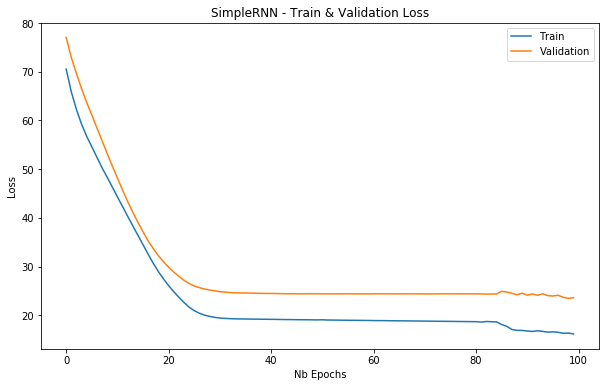

Minimum validation loss of 23.492153392118567 reached at epoch 98


In [155]:
plot_loss(simple_rnn_hist, 'SimpleRNN - Train & Validation Loss')

In [156]:
train_pred = simple_rnn.predict(x_train)
test_pred = simple_rnn.predict(x_test)

train_RMSE = mean_squared_error(y_train, train_pred) ** 0.5
test_RMSE = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE :', train_RMSE)
print('Test RMSE :', test_RMSE)

Train RMSE : 23.23517998710388
Test RMSE : 37.71782444725679


In [157]:
yy = simple_rnn.predict(x)
result = mean_squared_error(y, yy) ** 0.5
print("RMSE of 314 dataset :", result)

RMSE of 314 dataset : 26.69200521340075


In [348]:
# save model architecture
model_json = simple_rnn.to_json()
open('simple_rnn_with_100iterations.json', 'w').write(model_json)

# save model's learned weights
simple_rnn.save_weights('simple_rnn_weights_with_100iterations.h5', overwrite=True)

## 3-1. Simple LSTM

In [318]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(16, input_shape=(1, 23)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())
simple_lstm.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 16)                2560      
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 17        
Total params: 2,577
Trainable params: 2,577
Non-trainable params: 0
_________________________________________________________________


In [322]:
simple_lstm_hist = simple_lstm.fit(x_train, y_train,
                       epochs = 100,
                       batch_size = 1,
                       verbose = 1, 
                       validation_split=0.2)

Train on 200 samples, validate on 51 samples
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 70.1325 - val_loss: 78.4084
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 68.6292 - val_loss: 77.0527
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 67.3144 - val_loss: 75.8008
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 65.9646 - val_loss: 74.4792
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 64.4322 - val_loss: 72.6344
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 62.8594 - val_loss: 71.2313
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 61.5452 - val_loss: 69.8840
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - loss: 60.2941 - val_loss: 68.5651
Epoch 9/100
200/200 [==============================] - 0s 2ms/step - loss: 59.1479 - val_loss: 67.3315
Epoch 10/100
200/200 [======

## 3-2. Results

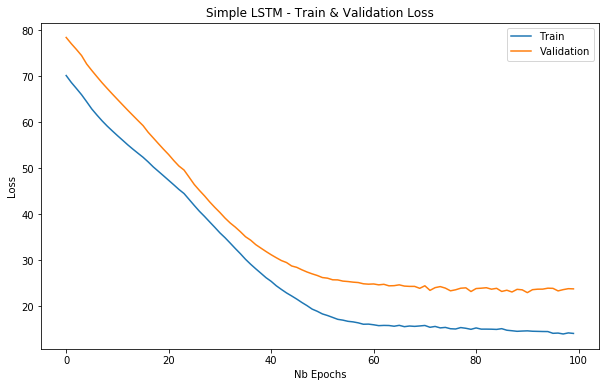

Minimum validation loss of 22.942065295051126 reached at epoch 90


In [323]:
plot_loss(simple_lstm_hist, 'Simple LSTM - Train & Validation Loss')

In [324]:
train_pred = simple_lstm.predict(x_train)
test_pred = simple_lstm.predict(x_test)

train_RMSE = mean_squared_error(y_train, train_pred) ** 0.5
test_RMSE = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE :', train_RMSE)
print('Test RMSE :', test_RMSE)

Train RMSE : 21.2162573860298
Test RMSE : 38.52582741978493


In [325]:
yy = simple_lstm.predict(x)
result = mean_squared_error(y, yy) ** 0.5
print("RMSE of 314 dataset :", result)

RMSE of 314 dataset : 25.551617402133502


In [349]:
# save model architecture
model_json = simple_lstm.to_json()
open('simple_lstm_with_100iterations.json', 'w').write(model_json)

# save model's learned weights
simple_lstm.save_weights('simple_lstm_weights_with_100iterations.h5', overwrite=True)

## 4-1. Stacked LSTM model

In [9]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(256, input_shape=(1, 23), return_sequences=True))
# stacked_lstm.add(Dropout(0.3))

stacked_lstm.add(LSTM(256, return_sequences=True))
# stacked_lstm.add(Dropout(0.3))

stacked_lstm.add(LSTM(256))
# stacked_lstm.add(Dropout(0.3))

stacked_lstm.add(Dense(32, activation = "relu"))

stacked_lstm.add(Dense(1))
stacked_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 256)            286720    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,345,601
Trainable params: 1,345,601
Non-trainable params: 0
_________________________________________________________________


In [13]:
losses = tf.compat.v1.losses.log_loss
stacked_lstm.compile(loss = root_mean_squared_error, optimizer='adam')

In [14]:
stacked_lstm_hist = stacked_lstm.fit(x_train, y_train,
                       epochs = 1000,
                       batch_size = 256,
                       verbose = 1, 
                       validation_split=0.2)

Train on 200 samples, validate on 51 samples
Epoch 1/1000
200/200 [==============================] - 2s 8ms/step - loss: 76.9693 - val_loss: 85.0637
Epoch 2/1000
200/200 [==============================] - 0s 460us/step - loss: 76.8792 - val_loss: 84.9556
Epoch 3/1000
200/200 [==============================] - 0s 300us/step - loss: 76.7690 - val_loss: 84.8050
Epoch 4/1000
200/200 [==============================] - 0s 280us/step - loss: 76.6208 - val_loss: 84.5944
Epoch 5/1000
200/200 [==============================] - 0s 280us/step - loss: 76.4136 - val_loss: 84.2999
Epoch 6/1000
200/200 [==============================] - 0s 285us/step - loss: 76.1203 - val_loss: 83.8904
Epoch 7/1000
200/200 [==============================] - 0s 275us/step - loss: 75.7163 - val_loss: 83.3357
Epoch 8/1000
200/200 [==============================] - 0s 330us/step - loss: 75.1741 - val_loss: 82.6221
Epoch 9/1000
200/200 [==============================] - 0s 325us/step - loss: 74.4775 - val_loss: 81.7292
Epo

Epoch 78/1000
200/200 [==============================] - 0s 295us/step - loss: 19.8030 - val_loss: 28.2232
Epoch 79/1000
200/200 [==============================] - 0s 290us/step - loss: 18.9176 - val_loss: 28.1701
Epoch 80/1000
200/200 [==============================] - 0s 285us/step - loss: 18.2447 - val_loss: 28.2315
Epoch 81/1000
200/200 [==============================] - 0s 300us/step - loss: 17.8959 - val_loss: 28.2181
Epoch 82/1000
200/200 [==============================] - 0s 310us/step - loss: 17.5731 - val_loss: 28.1633
Epoch 83/1000
200/200 [==============================] - 0s 290us/step - loss: 17.4698 - val_loss: 28.0822
Epoch 84/1000
200/200 [==============================] - 0s 290us/step - loss: 17.3310 - val_loss: 28.0102
Epoch 85/1000
200/200 [==============================] - 0s 285us/step - loss: 16.9703 - val_loss: 27.9249
Epoch 86/1000
200/200 [==============================] - 0s 310us/step - loss: 16.5886 - val_loss: 27.7906
Epoch 87/1000
200/200 [==============

Epoch 155/1000
200/200 [==============================] - 0s 290us/step - loss: 7.7052 - val_loss: 18.4478
Epoch 156/1000
200/200 [==============================] - 0s 300us/step - loss: 7.6464 - val_loss: 19.1634
Epoch 157/1000
200/200 [==============================] - 0s 290us/step - loss: 7.4032 - val_loss: 18.3927
Epoch 158/1000
200/200 [==============================] - 0s 290us/step - loss: 7.1935 - val_loss: 19.0728
Epoch 159/1000
200/200 [==============================] - 0s 290us/step - loss: 7.0388 - val_loss: 18.4267
Epoch 160/1000
200/200 [==============================] - 0s 300us/step - loss: 7.0211 - val_loss: 19.7666
Epoch 161/1000
200/200 [==============================] - 0s 295us/step - loss: 7.2283 - val_loss: 18.7381
Epoch 162/1000
200/200 [==============================] - 0s 303us/step - loss: 8.3379 - val_loss: 19.6955
Epoch 163/1000
200/200 [==============================] - 0s 290us/step - loss: 7.3464 - val_loss: 18.0515
Epoch 164/1000
200/200 [=============

Epoch 232/1000
200/200 [==============================] - 0s 295us/step - loss: 5.3325 - val_loss: 18.2343
Epoch 233/1000
200/200 [==============================] - 0s 295us/step - loss: 5.8563 - val_loss: 19.5731
Epoch 234/1000
200/200 [==============================] - 0s 305us/step - loss: 4.3858 - val_loss: 19.9423
Epoch 235/1000
200/200 [==============================] - 0s 305us/step - loss: 4.5807 - val_loss: 18.2515
Epoch 236/1000
200/200 [==============================] - 0s 285us/step - loss: 6.0256 - val_loss: 19.7862
Epoch 237/1000
200/200 [==============================] - 0s 315us/step - loss: 4.5265 - val_loss: 19.3791
Epoch 238/1000
200/200 [==============================] - 0s 280us/step - loss: 4.2274 - val_loss: 18.5441
Epoch 239/1000
200/200 [==============================] - 0s 305us/step - loss: 4.9583 - val_loss: 20.6227
Epoch 240/1000
200/200 [==============================] - 0s 295us/step - loss: 5.1437 - val_loss: 18.8145
Epoch 241/1000
200/200 [=============

Epoch 309/1000
200/200 [==============================] - 0s 290us/step - loss: 3.2214 - val_loss: 19.8483
Epoch 310/1000
200/200 [==============================] - 0s 310us/step - loss: 3.1823 - val_loss: 21.5940
Epoch 311/1000
200/200 [==============================] - 0s 285us/step - loss: 4.3552 - val_loss: 19.7464
Epoch 312/1000
200/200 [==============================] - 0s 315us/step - loss: 3.4684 - val_loss: 20.2465
Epoch 313/1000
200/200 [==============================] - 0s 300us/step - loss: 2.8956 - val_loss: 21.4028
Epoch 314/1000
200/200 [==============================] - 0s 290us/step - loss: 3.8702 - val_loss: 19.6046
Epoch 315/1000
200/200 [==============================] - 0s 290us/step - loss: 4.2410 - val_loss: 20.3674
Epoch 316/1000
200/200 [==============================] - 0s 310us/step - loss: 2.8401 - val_loss: 21.6647
Epoch 317/1000
200/200 [==============================] - 0s 290us/step - loss: 4.1524 - val_loss: 19.5678
Epoch 318/1000
200/200 [=============

Epoch 386/1000
200/200 [==============================] - 0s 295us/step - loss: 3.8245 - val_loss: 19.7586
Epoch 387/1000
200/200 [==============================] - 0s 310us/step - loss: 3.1293 - val_loss: 20.3802
Epoch 388/1000
200/200 [==============================] - 0s 320us/step - loss: 1.9969 - val_loss: 21.6584
Epoch 389/1000
200/200 [==============================] - 0s 300us/step - loss: 3.4906 - val_loss: 19.6346
Epoch 390/1000
200/200 [==============================] - 0s 315us/step - loss: 3.3748 - val_loss: 20.2390
Epoch 391/1000
200/200 [==============================] - 0s 290us/step - loss: 1.9865 - val_loss: 21.8642
Epoch 392/1000
200/200 [==============================] - 0s 305us/step - loss: 3.7771 - val_loss: 19.7520
Epoch 393/1000
200/200 [==============================] - 0s 300us/step - loss: 3.0951 - val_loss: 20.4215
Epoch 394/1000
200/200 [==============================] - 0s 295us/step - loss: 1.9240 - val_loss: 21.5355
Epoch 395/1000
200/200 [=============

Epoch 463/1000
200/200 [==============================] - 0s 300us/step - loss: 3.3434 - val_loss: 19.3217
Epoch 464/1000
200/200 [==============================] - 0s 305us/step - loss: 4.3459 - val_loss: 19.3768
Epoch 465/1000
200/200 [==============================] - 0s 290us/step - loss: 4.2741 - val_loss: 20.5322
Epoch 466/1000
200/200 [==============================] - 0s 300us/step - loss: 2.8531 - val_loss: 20.4608
Epoch 467/1000
200/200 [==============================] - 0s 305us/step - loss: 3.1304 - val_loss: 18.7903
Epoch 468/1000
200/200 [==============================] - 0s 295us/step - loss: 3.2523 - val_loss: 18.7628
Epoch 469/1000
200/200 [==============================] - 0s 310us/step - loss: 2.6788 - val_loss: 20.9129
Epoch 470/1000
200/200 [==============================] - 0s 300us/step - loss: 3.7394 - val_loss: 20.6445
Epoch 471/1000
200/200 [==============================] - 0s 305us/step - loss: 2.5502 - val_loss: 19.2943
Epoch 472/1000
200/200 [=============

Epoch 540/1000
200/200 [==============================] - 0s 295us/step - loss: 3.4057 - val_loss: 19.4377
Epoch 541/1000
200/200 [==============================] - 0s 300us/step - loss: 3.0817 - val_loss: 20.7790
Epoch 542/1000
200/200 [==============================] - 0s 310us/step - loss: 2.9262 - val_loss: 20.5756
Epoch 543/1000
200/200 [==============================] - 0s 310us/step - loss: 2.5507 - val_loss: 19.3760
Epoch 544/1000
200/200 [==============================] - 0s 300us/step - loss: 3.2685 - val_loss: 19.3695
Epoch 545/1000
200/200 [==============================] - 0s 320us/step - loss: 2.8121 - val_loss: 20.8357
Epoch 546/1000
200/200 [==============================] - 0s 310us/step - loss: 3.3436 - val_loss: 20.5471
Epoch 547/1000
200/200 [==============================] - 0s 320us/step - loss: 2.8144 - val_loss: 19.1132
Epoch 548/1000
200/200 [==============================] - 0s 315us/step - loss: 3.3525 - val_loss: 19.1886
Epoch 549/1000
200/200 [=============

Epoch 617/1000
200/200 [==============================] - 0s 305us/step - loss: 3.8439 - val_loss: 20.2087
Epoch 618/1000
200/200 [==============================] - 0s 300us/step - loss: 1.6135 - val_loss: 20.6486
Epoch 619/1000
200/200 [==============================] - 0s 315us/step - loss: 2.5298 - val_loss: 19.5368
Epoch 620/1000
200/200 [==============================] - 0s 300us/step - loss: 1.7866 - val_loss: 19.6992
Epoch 621/1000
200/200 [==============================] - 0s 305us/step - loss: 1.4982 - val_loss: 20.8657
Epoch 622/1000
200/200 [==============================] - 0s 310us/step - loss: 2.6857 - val_loss: 20.0544
Epoch 623/1000
200/200 [==============================] - 0s 300us/step - loss: 1.2949 - val_loss: 19.2470
Epoch 624/1000
200/200 [==============================] - 0s 305us/step - loss: 3.0332 - val_loss: 19.5556
Epoch 625/1000
200/200 [==============================] - 0s 300us/step - loss: 1.5691 - val_loss: 21.5005
Epoch 626/1000
200/200 [=============

Epoch 694/1000
200/200 [==============================] - 0s 295us/step - loss: 2.6230 - val_loss: 19.3352
Epoch 695/1000
200/200 [==============================] - 0s 305us/step - loss: 2.8810 - val_loss: 19.3684
Epoch 696/1000
200/200 [==============================] - 0s 310us/step - loss: 3.0798 - val_loss: 20.2965
Epoch 697/1000
200/200 [==============================] - 0s 300us/step - loss: 1.7373 - val_loss: 20.2702
Epoch 698/1000
200/200 [==============================] - 0s 300us/step - loss: 1.8881 - val_loss: 19.2231
Epoch 699/1000
200/200 [==============================] - 0s 325us/step - loss: 2.3750 - val_loss: 19.3268
Epoch 700/1000
200/200 [==============================] - 0s 305us/step - loss: 1.6636 - val_loss: 20.8538
Epoch 701/1000
200/200 [==============================] - 0s 305us/step - loss: 3.3371 - val_loss: 20.5852
Epoch 702/1000
200/200 [==============================] - 0s 305us/step - loss: 2.4708 - val_loss: 19.3382
Epoch 703/1000
200/200 [=============

Epoch 771/1000
200/200 [==============================] - 0s 325us/step - loss: 2.5016 - val_loss: 19.3039
Epoch 772/1000
200/200 [==============================] - 0s 315us/step - loss: 2.4595 - val_loss: 20.3551
Epoch 773/1000
200/200 [==============================] - 0s 300us/step - loss: 2.0051 - val_loss: 20.1934
Epoch 774/1000
200/200 [==============================] - 0s 310us/step - loss: 1.7767 - val_loss: 19.1762
Epoch 775/1000
200/200 [==============================] - 0s 310us/step - loss: 2.6036 - val_loss: 19.1907
Epoch 776/1000
200/200 [==============================] - 0s 310us/step - loss: 2.1819 - val_loss: 20.3939
Epoch 777/1000
200/200 [==============================] - 0s 325us/step - loss: 2.5556 - val_loss: 20.3119
Epoch 778/1000
200/200 [==============================] - 0s 300us/step - loss: 2.2458 - val_loss: 19.2226
Epoch 779/1000
200/200 [==============================] - 0s 300us/step - loss: 2.4909 - val_loss: 19.2724
Epoch 780/1000
200/200 [=============

Epoch 848/1000
200/200 [==============================] - 0s 295us/step - loss: 2.1245 - val_loss: 20.1890
Epoch 849/1000
200/200 [==============================] - 0s 305us/step - loss: 2.2346 - val_loss: 20.1208
Epoch 850/1000
200/200 [==============================] - 0s 310us/step - loss: 1.9768 - val_loss: 19.1451
Epoch 851/1000
200/200 [==============================] - 0s 290us/step - loss: 2.3609 - val_loss: 19.2035
Epoch 852/1000
200/200 [==============================] - 0s 300us/step - loss: 2.2240 - val_loss: 20.2655
Epoch 853/1000
200/200 [==============================] - 0s 310us/step - loss: 1.9847 - val_loss: 20.1289
Epoch 854/1000
200/200 [==============================] - 0s 290us/step - loss: 1.7548 - val_loss: 19.1066
Epoch 855/1000
200/200 [==============================] - 0s 365us/step - loss: 2.4141 - val_loss: 19.1102
Epoch 856/1000
200/200 [==============================] - 0s 365us/step - loss: 2.1184 - val_loss: 20.1800
Epoch 857/1000
200/200 [=============

Epoch 925/1000
200/200 [==============================] - 0s 320us/step - loss: 1.9018 - val_loss: 20.0432
Epoch 926/1000
200/200 [==============================] - 0s 305us/step - loss: 1.6829 - val_loss: 19.0647
Epoch 927/1000
200/200 [==============================] - 0s 300us/step - loss: 2.2807 - val_loss: 19.0692
Epoch 928/1000
200/200 [==============================] - 0s 303us/step - loss: 2.0289 - val_loss: 20.0702
Epoch 929/1000
200/200 [==============================] - 0s 300us/step - loss: 2.0315 - val_loss: 20.0131
Epoch 930/1000
200/200 [==============================] - 0s 310us/step - loss: 1.7971 - val_loss: 19.1052
Epoch 931/1000
200/200 [==============================] - 0s 315us/step - loss: 2.2400 - val_loss: 19.1596
Epoch 932/1000
200/200 [==============================] - 0s 300us/step - loss: 2.0789 - val_loss: 20.1636
Epoch 933/1000
200/200 [==============================] - 0s 325us/step - loss: 1.8922 - val_loss: 20.0347
Epoch 934/1000
200/200 [=============

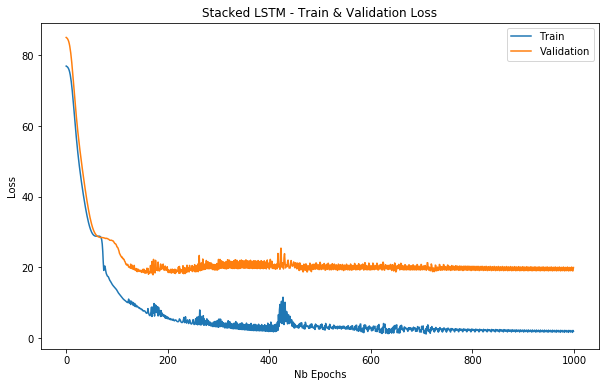

Minimum validation loss of 17.911134719848633 reached at epoch 171


In [18]:
plot_loss(stacked_lstm_hist, 'Stacked LSTM - Train & Validation Loss')

In [26]:
train_pred = stacked_lstm.predict(x_train)
test_pred = stacked_lstm.predict(x_test)

train_RMSE = mean_squared_error(y_train, train_pred) ** 0.5
test_RMSE = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE :', train_RMSE)
print('Test RMSE :', test_RMSE)

Train RMSE : 9.160361204530785
Test RMSE : 25.289991892787643


In [27]:
yy = stacked_lstm.predict(x)
result = mean_squared_error(y, yy) ** 0.5
print("RMSE of 314 dataset :", result)

RMSE of 314 dataset : 13.910436884542378


In [ ]:
# save model architecture
model_json = stacked_lstm.to_json()
open('stacked_lstm_with_100iterations.json', 'w').write(model_json)

# save model's learned weights
stacked_lstm.save_weights('stacked_lstm_weights_with_100iterations.h5', overwrite=True)

## 5. Visualization

In [37]:
zz = yy
zz.shape

(314, 1)

In [32]:
dataset = pd.read_csv("air_pollution_new/Hour_1.csv", header = None)
data = dataset.values[:,:]

latitude = data[:,1]
longitude = data[:,2]

In [33]:
coo = []

for i in range(len(prediction)):
    coo.append([latitude[i], longitude[i]])

In [36]:
coo = np.array(coo)
coo1 = np.array(coo[:,0])
coo2 = np.array(coo[:,1])

In [38]:
print(coo.shape)
print(coo1.shape)
print(coo2.shape)
print(zz.shape)

(314, 2)
(314,)
(314,)
(314, 1)


In [41]:
X1 = coo
z1 = zz
idw_tree = idw.tree(X1, z1)
new_lat = np.linspace(34,37.5,100)
new_lon = np.linspace(126.5,130,100)

X2 = np.meshgrid(new_lat, new_lon)
grid_shape = X2[0].shape
X2 = np.reshape(X2, (2, -1)).T
z2 = idw_tree(X2)

In [46]:
z2.shape

(10000,)

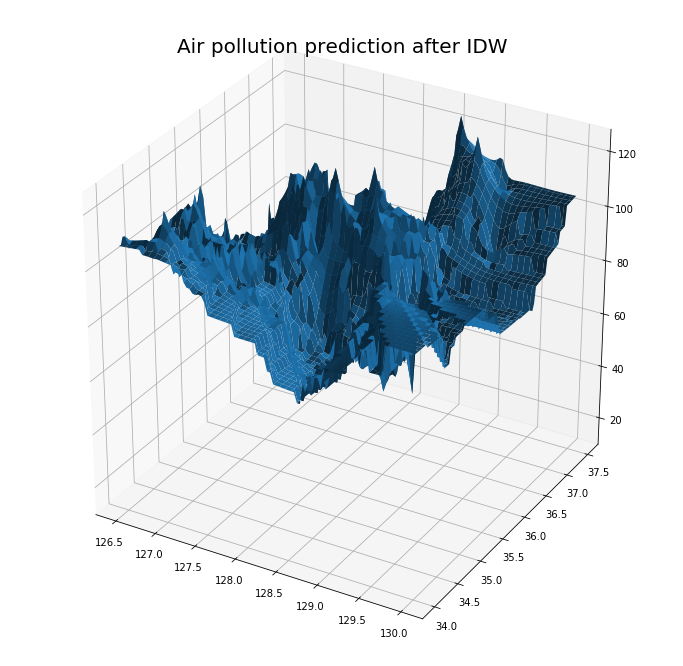

In [47]:
X21, X22 = np.meshgrid(new_lat, new_lon)

plt.rcParams["figure.figsize"] = (12,12)
fig = plt.figure()
ax3 = fig.gca(projection = '3d')
ax3.plot_surface(X22, X21 , z2.reshape(grid_shape))

plt.title("Air pollution prediction after IDW", fontsize=20)
# plt.savefig("fig5.jpg")
plt.show()

In [48]:
np.savetxt('LSTM_pred.txt', z2.reshape(grid_shape))